# Import Libraries & Data Files

In [1]:
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf

from pathlib import Path
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import model_from_json


In [4]:
# Load bank failure data by selecting from the upload prompt
from google.colab import files
uploaded = files.upload()

Saving bankdata.csv to bankdata.csv


In [5]:
# load  and create model
bank_data = pd.read_csv(Path("bankdata.csv"))
display(bank_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89334 entries, 0 to 89333
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cert            89334 non-null  float64
 1   quarter         89334 non-null  object 
 2   name            89334 non-null  object 
 3   city            89334 non-null  object 
 4   state           89334 non-null  object 
 5   assets          89334 non-null  float64
 6   cash            89334 non-null  object 
 7   securities      89334 non-null  object 
 8   loans           89334 non-null  object 
 9   total_deposits  89334 non-null  object 
 10  core_deposits   89334 non-null  object 
dtypes: float64(2), object(9)
memory usage: 7.5+ MB


None

In [6]:
#List headers
bank_data.columns

Index(['cert', 'quarter', 'name', 'city', 'state', 'assets', 'cash',
       'securities', 'loans', 'total_deposits', 'core_deposits'],
      dtype='object')

In [7]:
#View Dataframe
bank_data.head()

,cert,quarter,name,city,state,assets,cash,securities,loans,total_deposits,core_deposits
0,10055.0,6/30/19,First Southern Bank,Waycross,GA,121183000.0,19022000.00,16735000.00,76319000.00,102008000.00,99717000.00
1,10057.0,6/30/19,Bank of Hancock County,Sparta,GA,74991000.0,5645000.00,43898000.00,24296000.00,58700000.00,57574000.00
2,10074.0,6/30/19,Apex Banking Company of Georgia,Irwinton,GA,47844000.0,2523000.00,18830000.00,26130000.00,39622000.00,38623000.00
3,10077.0,6/30/19,Farmers State Bank of Emden,Emden,IL,33873000.0,947000.00,19617000.00,9544000.00,24165000.00,23270000.00
4,1008.0,6/30/19,Bank Michigan,Brooklyn,MI,106265000.0,11968000.00,11140000.00,77454000.00,88113000.00,77188000.00


# Clean Data

In [8]:
#Check columns for null values
columns_to_check = ['assets', 'cash', 'securities', 'loans', 'total_deposits', 'core_deposits']
for column in columns_to_check:
    bank_data[column] = bank_data[column].replace(" $-   ", np.nan)

#Drop null values
bank_data.dropna(inplace=True)

#Convert columns to floats and dates
bank_data['assets'] = bank_data['assets'].astype(float)
bank_data['cash'] = bank_data['cash'].astype(float)
bank_data['securities'] = bank_data['securities'].astype(float)
bank_data['loans'] = bank_data['loans'].astype(float)
bank_data['total_deposits'] = bank_data['total_deposits'].astype(float)
bank_data['core_deposits'] = bank_data['core_deposits'].astype(float)
bank_data['quarter'] = pd.to_datetime(bank_data['quarter'])

In [9]:
#Check data
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86476 entries, 0 to 89333
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cert            86476 non-null  float64       
 1   quarter         86476 non-null  datetime64[ns]
 2   name            86476 non-null  object        
 3   city            86476 non-null  object        
 4   state           86476 non-null  object        
 5   assets          86476 non-null  float64       
 6   cash            86476 non-null  float64       
 7   securities      86476 non-null  float64       
 8   loans           86476 non-null  float64       
 9   total_deposits  86476 non-null  float64       
 10  core_deposits   86476 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(3)
memory usage: 7.9+ MB


In [10]:
#Create identifier ratios for potential "riskiness" rating
#Create Security to Asset Ratio (high is risky)
bank_data["S/A Ratio"] = bank_data['securities']/bank_data['assets']
#Create Cash to Assets Ratio (low is risky)
bank_data["C/A Ratio"] = bank_data['cash']/bank_data['assets']
#Create Loans to Total Depositis Ratio (high is risky)
bank_data["L/D Ratio"] = bank_data['loans']/bank_data['total_deposits']
bank_data.head()

,cert,quarter,name,city,state,assets,cash,securities,loans,total_deposits,core_deposits,S/A Ratio,C/A Ratio,L/D Ratio
0,10055.0,2019-06-30,First Southern Bank,Waycross,GA,121183000.0,19022000.0,16735000.0,76319000.0,102008000.0,99717000.0,0.138097,0.156969,0.748167
1,10057.0,2019-06-30,Bank of Hancock County,Sparta,GA,74991000.0,5645000.0,43898000.0,24296000.0,58700000.0,57574000.0,0.585377,0.075276,0.413901
2,10074.0,2019-06-30,Apex Banking Company of Georgia,Irwinton,GA,47844000.0,2523000.0,18830000.0,26130000.0,39622000.0,38623000.0,0.393571,0.052734,0.659482
3,10077.0,2019-06-30,Farmers State Bank of Emden,Emden,IL,33873000.0,947000.0,19617000.0,9544000.0,24165000.0,23270000.0,0.579134,0.027957,0.394951
4,1008.0,2019-06-30,Bank Michigan,Brooklyn,MI,106265000.0,11968000.0,11140000.0,77454000.0,88113000.0,77188000.0,0.104832,0.112624,0.879030


In [11]:
#Group data for time series data analysis
grouped_data = bank_data.groupby(['cert', 'quarter']).sum()
pd.options.display.float_format = '{:.4f}'.format

<ipython-input-11-5cb03c361798>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = bank_data.groupby(['cert', 'quarter']).sum()


In [12]:
# Percent change column for all metrics QoQ
grouped_data_pct_change = grouped_data.pct_change()
grouped_data_pct_change.rename(columns = {'assets':'assets_pct',	'cash':'cash_pct','securities':'securities_pct','loans':'loans_pct',	'total_deposits':'total_deposits_pct','core_deposits':'core_deposits_pct','S/A Ratio':'S/A Ratio_pct','C/A Ratio':'C/A Ratio_pct','L/D Ratio':'L/D Ratio_pct'}, inplace=True)
grouped_data_pct_change = pd.concat([grouped_data_pct_change, grouped_data[['S/A Ratio',	'C/A Ratio',	'L/D Ratio']]], axis=1)

In [13]:
# Filter and drop rows with the specified date within each group
rows_to_drop = grouped_data_pct_change.loc[(slice(None), '2019-03-31'), :]
grouped_data_pct_change.drop(rows_to_drop.index, inplace=True)
grouped_data_pct_change.head(5)

assets_pct  cash_pct  securities_pct  loans_pct  \
cert    quarter                                                       
14.0000 2019-06-30      0.0577    0.1377          0.0259     0.0869   
        2019-09-30      0.0136   -0.0035          0.0152     0.0624   
        2019-12-31      0.0032    0.0966          0.0181    -0.0260   
        2020-03-31      0.4834    1.2977          0.1654     0.2293   
        2020-06-30     -0.2294   -0.3932         -0.0773    -0.1717   

                    total_deposits_pct  core_deposits_pct  S/A Ratio_pct  \
cert    quarter                                                            
14.0000 2019-06-30              0.0486             0.0725        -0.0300   
        2019-09-30              0.0030             0.0895         0.0015   
        2019-12-31              0.0660             0.0678         0.0148   
        2020-03-31              0.4039             0.5811        -0.2143   
        2020-06-30             -0.2105             0.0455         0.1973   

                    C/A Ratio_pct  L/D Ratio_pct  S/A Ratio  C/A Ratio  \
cert    quarter                                                          
14.0000 2019-06-30         0.0757         0.0365     0.3874     0.2751   
        2019-09-30        -0.0169         0.0592     0.3879     0.2705   
        2019-12-31         0.0930        -0.0863     0.3937     0.2956   
        2020-03-31         0.5490        -0.1244     0.3093     0.4579   
        2020-06-30        -0.2126         0.0492     0.3703     0.3606   

                    L/D Ratio  
cert    quarter                
14.0000 2019-06-30     0.1452  
        2019-09-30     0.1538  
        2019-12-31     0.1405  
        2020-03-31     0.1230  
        2020-06-30     0.1291

In [14]:
# Remove final last quarter of data for bank model identification purposes at end of project
projection_df = grouped_data_pct_change.loc[(slice(None), '2023-06-30'), :]
projection_df = pd.concat([projection_df,grouped_data],axis=1)
projection_df.dropna(inplace=True)
projection_df.drop(columns=['S/A Ratio_pct','C/A Ratio_pct','L/D Ratio_pct','S/A Ratio','C/A Ratio','L/D Ratio'],inplace=True)
projection_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4520 entries, (14.0, Timestamp('2023-06-30 00:00:00')) to (91280.0, Timestamp('2023-06-30 00:00:00'))
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   assets_pct          4520 non-null   float64
 1   cash_pct            4520 non-null   float64
 2   securities_pct      4520 non-null   float64
 3   loans_pct           4520 non-null   float64
 4   total_deposits_pct  4520 non-null   float64
 5   core_deposits_pct   4520 non-null   float64
 6   assets              4520 non-null   float64
 7   cash                4520 non-null   float64
 8   securities          4520 non-null   float64
 9   loans               4520 non-null   float64
 10  total_deposits      4520 non-null   float64
 11  core_deposits       4520 non-null   float64
dtypes: float64(12)
memory usage: 608.1 KB


In [15]:
#Create model dataframe
rows_to_drop = grouped_data_pct_change.loc[(slice(None), '2023-06-30'), :]
grouped_data_pct_change.drop(rows_to_drop.index, inplace=True)

In [16]:
# Identify banks that are overexposed
grouped_data_pct_change["Risky"] = np.nan

for data in grouped_data_pct_change.index:
  if (grouped_data_pct_change["S/A Ratio"][data] >= 0.20 and grouped_data_pct_change["C/A Ratio"][data] <= 0.05 and grouped_data_pct_change["L/D Ratio"][data] >= 0.70):
    grouped_data_pct_change["Risky"][data] = 1
  else:
    grouped_data_pct_change["Risky"][data] = 0

grouped_data_pct_change["Risky"].value_counts()

0.0000    71430
1.0000     5353
Name: Risky, dtype: int64

In [17]:
#Add in original numeric data
grouped_data_pct_change_final = pd.concat([grouped_data_pct_change,grouped_data[['assets', 'cash', 'securities', 'loans', 'total_deposits', 'core_deposits']]],axis=1)
grouped_data_pct_change_final.drop(columns=['S/A Ratio_pct',	'C/A Ratio_pct',	'L/D Ratio_pct',	'S/A Ratio',	'C/A Ratio',	'L/D Ratio'], inplace=True)
grouped_data_pct_change_final.dropna(inplace=True)

# MODEL DATA

In [18]:
#Set X & y variables
X = grouped_data_pct_change_final[['assets_pct','cash_pct','securities_pct','loans_pct','total_deposits_pct','core_deposits_pct','assets', 'cash', 'securities', 'loans', 'total_deposits', 'core_deposits']]
y = grouped_data_pct_change_final[['Risky']]
X = X.reset_index(drop=True)

In [19]:
# Split into training and testing windows
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [20]:
# Create the StandardScaler instance
X_scaler = Normalizer()

# Fit the scaler to the features training dataset
X_scaler.fit(X_train)

# Scale both the training and testing data from the features dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Define the the number of inputs to the model
number_input_features = 12

# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 = 40

# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 = .5*hidden_nodes_layer1

# Define the number of hidden nodes for the third hidden layer
hidden_nodes_layer3 = .5*hidden_nodes_layer2

In [ ]:
# Create the Sequential model instance
nn = Sequential()

In [ ]:
# Add the first Dense layer specifying the number of inputs, the number of hidden nodes, and the activation function
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Add the second Dense layer specifying the number of hidden nodes and the activation function
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))

nn.add(Dropout(.2,input_shape=(hidden_nodes_layer2,)))

# Add the third Dense layer specifying the number of hidden nodes and the activation function
nn.add(Dense(units=hidden_nodes_layer3, activation="relu"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units=1, activation="sigmoid"))

In [ ]:
# View Model Structure
nn.summary()


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 40)                520       
                                                                 
 dense_157 (Dense)           (None, 20)                820       
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                                 
 dense_158 (Dense)           (None, 10)                210       
                                                                 
 dense_159 (Dense)           (None, 1)                 11        
                                                                 
Total params: 1561 (6.10 KB)
Trainable params: 1561 (6.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Fit the model
nn.fit(X_train_scaled,y_train,
                    epochs=50,
                    batch_size=100,
                    shuffle=True)

Epoch 1/50
576/576 [==============================] - 2s 2ms/step - loss: 0.2797 - accuracy: 0.9225
Epoch 2/50
576/576 [==============================] - 1s 2ms/step - loss: 0.1233 - accuracy: 0.9312
Epoch 3/50
576/576 [==============================] - 1s 2ms/step - loss: 0.0807 - accuracy: 0.9699
Epoch 4/50
576/576 [==============================] - 1s 2ms/step - loss: 0.0721 - accuracy: 0.9783
Epoch 5/50
576/576 [==============================] - 1s 2ms/step - loss: 0.0651 - accuracy: 0.9792
Epoch 6/50
576/576 [==============================] - 1s 2ms/step - loss: 0.0592 - accuracy: 0.9800
Epoch 7/50
576/576 [==============================] - 1s 2ms/step - loss: 0.0518 - accuracy: 0.9798
Epoch 8/50
576/576 [==============================] - 1s 3ms/step - loss: 0.0470 - accuracy: 0.9812
Epoch 9/50
576/576 [==============================] - 2s 3ms/step - loss: 0.0445 - accuracy: 0.9816
Epoch 10/50
576/576 [==============================] - 2s 3ms/step - loss: 0.0440 - accuracy: 0.9817

In [ ]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)

600/600 - 1s - loss: 0.0166 - accuracy: 0.9941 - 893ms/epoch - 1ms/step


In [ ]:
# Display the evaluation results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Loss: 0.0166209414601326, Accuracy: 0.994061291217804


In [ ]:
# Predict values on test data
predictions = nn.predict(X_test)
predictions

600/600 [==============================] - 1s 1ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
# Print classification reports
print(f"Classifiction Report - Original Data")
print(classification_report(y_test, predictions,target_names=["Non-Risky", "Risky"]))

Classifiction Report - Original Data
              precision    recall  f1-score   support

   Non-Risky       0.98      0.97      0.98     17806
       Risky       0.69      0.77      0.73      1390

    accuracy                           0.96     19196
   macro avg       0.84      0.87      0.85     19196
weighted avg       0.96      0.96      0.96     19196



# Save model

In [ ]:
# Save model as JSON
nn_json = nn.to_json()

file_path = ("risky_bank_model_final.json")
with open(file_path, "w") as json_file:
    json_file.write(nn_json)

# Save weights
file_path = "risky_bank_model_weights_final.h5"
nn.save_weights(file_path)

# Load trained model

In [21]:
# Identify the relative path of the model's location
file_path = "drive/MyDrive/Colab Notebooks/risky_bank_model_final.json"

# Read in the model and save it as the variable loaded_model
with open(file_path, "r") as json_file:
    model_json = json_file.read()
loaded_model = model_from_json(model_json)

# Identify the relative path for the model's weights
file_path = "drive/MyDrive/Colab Notebooks/risky_bank_model_weights_final.h5"

# Load the model's weights to the variable loaded_model
loaded_model.load_weights(file_path)

# Predict risky banks from Q2'23 with the model

In [22]:
# Test model on current quarter's data to predict bank risk
output_df = projection_df.reset_index(drop=True)

predictions = loaded_model.predict(output_df)
predictions

142/142 [==============================] - 1s 2ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [23]:
# View columns & counts
projection_df.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4520 entries, (14.0, Timestamp('2023-06-30 00:00:00')) to (91280.0, Timestamp('2023-06-30 00:00:00'))
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   assets_pct          4520 non-null   float64
 1   cash_pct            4520 non-null   float64
 2   securities_pct      4520 non-null   float64
 3   loans_pct           4520 non-null   float64
 4   total_deposits_pct  4520 non-null   float64
 5   core_deposits_pct   4520 non-null   float64
 6   assets              4520 non-null   float64
 7   cash                4520 non-null   float64
 8   securities          4520 non-null   float64
 9   loans               4520 non-null   float64
 10  total_deposits      4520 non-null   float64
 11  core_deposits       4520 non-null   float64
dtypes: float64(12)
memory usage: 608.1 KB


In [24]:
#Add prediciton to dataframe
output_df["Riskiness Prediction"] = predictions
output_df["Riskiness Prediction"].value_counts()
output_df["Riskiness Prediction"].loc[output_df["Riskiness Prediction"]==0.0000] = 'Non-Risky'
output_df["Riskiness Prediction"].loc[output_df["Riskiness Prediction"]==1.0000] = 'Risky'
#output_df = pd.concat([projection_df.multi_index['cert'],output_df],axis=1)
#output_df.head()

# Assuming 'cert' is one of the levels in your MultiIndex DataFrame
cert_values = projection_df.index.get_level_values('cert')

# Create a new DataFrame with 'cert' values and concatenate it with output_df
cert_df = pd.DataFrame(cert_values, columns=['cert'])
output_df = pd.concat([cert_df, output_df], axis=1)
output_df.tail()

<ipython-input-24-439ebf2264b5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df["Riskiness Prediction"].loc[output_df["Riskiness Prediction"]==0.0000] = 'Non-Risky'


,cert,assets_pct,cash_pct,securities_pct,loans_pct,total_deposits_pct,core_deposits_pct,assets,cash,securities,loans,total_deposits,core_deposits,Riskiness Prediction
4515,90308.0000,0.0356,-0.0194,-0.0226,0.0471,0.0251,-0.0036,746883000.0000,52178000.0000,73388000.0000,596615000.0000,578198000.0000,473475000.0000,Non-Risky
4516,90311.0000,0.0071,0.0924,-0.0211,0.0044,0.0780,0.0084,538138000.0000,29787000.0000,48912000.0000,437669000.0000,481831000.0000,401752000.0000,Non-Risky
4517,90384.0000,0.0074,0.3507,-0.0247,-0.0019,0.0111,0.0087,368265000.0000,19137000.0000,73332000.0000,259233000.0000,312266000.0000,295790000.0000,Non-Risky
4518,91005.0000,0.0026,-0.0532,-0.0224,0.0005,-0.0503,-0.0687,355635000.0000,4537000.0000,21563000.0000,318588000.0000,266247000.0000,250066000.0000,Non-Risky
4519,91280.0000,0.0791,0.1335,-0.0267,0.1817,0.0378,-0.0074,304331000.0000,6071000.0000,163253000.0000,115978000.0000,267473000.0000,237694000.0000,Non-Risky


In [25]:
# Filter data to Q2'23 and merge dataframes to add the original name and data to the output
bank_data = bank_data.loc[bank_data['quarter']== '2023-06-30']
risky_bank_prediction = output_df.merge(bank_data, on='cert', how='inner', suffixes=('_1', '_2'))
risky_bank_prediction['Riskiness Prediction'].value_counts()

Non-Risky    3823
Risky         697
Name: Riskiness Prediction, dtype: int64

In [26]:
# View new dataframe info
risky_bank_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4520 entries, 0 to 4519
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   cert                  4520 non-null   float64       
 1   assets_pct            4520 non-null   float64       
 2   cash_pct              4520 non-null   float64       
 3   securities_pct        4520 non-null   float64       
 4   loans_pct             4520 non-null   float64       
 5   total_deposits_pct    4520 non-null   float64       
 6   core_deposits_pct     4520 non-null   float64       
 7   assets_1              4520 non-null   float64       
 8   cash_1                4520 non-null   float64       
 9   securities_1          4520 non-null   float64       
 10  loans_1               4520 non-null   float64       
 11  total_deposits_1      4520 non-null   float64       
 12  core_deposits_1       4520 non-null   float64       
 13  Riskiness Predicti

In [27]:
# Drop columns that are duplicates or not needed
columns_to_drop = ['assets_2','cash_2','securities_2','loans_2','total_deposits_2','core_deposits_2','quarter']

risky_bank_prediction.drop(columns=columns_to_drop, inplace=True)

In [28]:
# Rename columns
risky_bank_prediction.rename(columns = {
    'cert':'Cert #',
    'assets_pct': 'Assets QoQ Pct',
    'cash_pct': 'Cash QoQ Pct',
    'securities_pct':'Securities QoQ Pct',
    'loans_pct':'Loans QoQ Pct',
    'total_deposits_pct':'Total Deposits QoQ Pct',
    'core_deposits_pct':'Core QoQ Pct',
    'assets_1':'Assets',
    'cash_1':'Cash',
    'securities_1':'Securities',
    'loans_1':'Loans',
    'total_deposits_1':'Total Deposits',
    'core_deposits_1':'Core Deposits',
    'Riskiness Prediction':"Risk Prediction",
    'quarter':'Quarter',
    'name':'Bank Name',
    'city':'City',
    'state':'State',
    'S/A Ratio':'S/A Ratio',
    'C/A Ratio':'C/A Ratio',
    'L/D Ratio':'L/D Ratio'
},inplace=True)

In [29]:
# Set index to the bank name
risky_bank_prediction.set_index('Bank Name', inplace=True)

risky_bank_prediction.head()

,Cert #,Assets QoQ Pct,Cash QoQ Pct,Securities QoQ Pct,Loans QoQ Pct,Total Deposits QoQ Pct,Core QoQ Pct,Assets,Cash,Securities,Loans,Total Deposits,Core Deposits,Risk Prediction,City,State,S/A Ratio,C/A Ratio,L/D Ratio
Bank Name,,,,,,,,,,,,,,,,,,,
State Street Bank and Trust Company,14.0000,0.0133,-0.0166,-0.0121,0.0059,-0.0053,0.0237,290889000000.0000,89454000000.0000,106267000000.0000,34225000000.0000,229272000000.0000,150518000000.0000,Non-Risky,Boston,MA,0.3653,0.3075,0.1493
AuburnBank,35.0000,0.0082,0.1855,-0.0286,0.0312,0.0122,-0.0173,1025574000.0000,28340000.0000,394079000.0000,513777000.0000,952201000.0000,862641000.0000,Non-Risky,Auburn,AL,0.3843,0.0276,0.5396
Robertson Banking Company,39.0000,-0.0121,-0.1574,-0.0192,0.0246,-0.0108,-0.0189,449565000.0000,30676000.0000,103185000.0000,296337000.0000,408328000.0000,372896000.0000,Non-Risky,Demopolis,AL,0.2295,0.0682,0.7257
Phenix-Girard Bank,41.0000,-0.0274,-0.3824,-0.0045,0.0614,-0.0255,-0.0239,259630000.0000,17291000.0000,152647000.0000,78612000.0000,254377000.0000,253448000.0000,Non-Risky,Phenix City,AL,0.5879,0.0666,0.3090
Bank of Evergreen,49.0000,-0.0305,-0.0572,-0.0165,0.0247,-0.0529,-0.0565,72947000.0000,6410000.0000,39248000.0000,24381000.0000,65596000.0000,61314000.0000,Non-Risky,Evergreen,AL,0.5380,0.0879,0.3717


In [30]:
# Create list of risky banks
bank_list = risky_bank_prediction.loc[risky_bank_prediction['Risk Prediction'] == "Risky"]
display(bank_list.index)

Index(['Commercial Bank & Trust Company', 'Bank of Cave City',
       'Bank of Madison', 'Exchange Bank', 'Tri-County Bank & Trust Company',
       'Solon State Bank', 'Stock Yards Bank & Trust Company',
       'Kentucky Farmers Bank', 'Morgantown Bank & Trust Company',
       'Community Financial Services Bank',
       ...
       'Redstone Bank', 'Lakeside Bank', 'BankUnited', 'Gulf Capital Bank',
       'Athol Savings Bank', 'Bluestone Bank', 'Clinton Savings Bank',
       'Middlesex Savings Bank', 'Cape Ann Savings Bank',
       'North Brookfield Savings Bank'],
      dtype='object', name='Bank Name', length=697)

In [94]:
# Save risky bank data to csv file
filename = 'model_output.csv'
non_risky_bank_count = 3823
risky_bank_count = 697

# Open the output path as a csv
bank_list.to_csv(filename, sep=',', index=True)

# Visualize the Data

In [81]:
# Import libraries for visualization
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

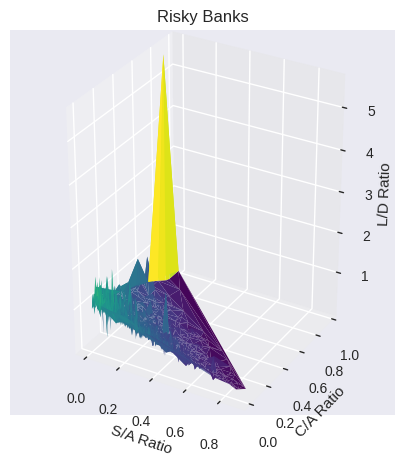

In [103]:
# Define function to determine
# Source: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.12-Three-Dimensional-Plotting.ipynb
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

theta = 2 * np.pi * np.random.random(4520)
r = 6 * np.random.random(4520)
x = risky_bank_prediction['S/A Ratio']
y = risky_bank_prediction['C/A Ratio']
z = risky_bank_prediction['L/D Ratio']

fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')

ax.set_xlabel('S/A Ratio')
ax.set_ylabel('C/A Ratio')
ax.set_zlabel('L/D Ratio')
ax.set_title('Risky Banks')
ax.set_box_aspect([3.5,3.5, 5])

plt.show()

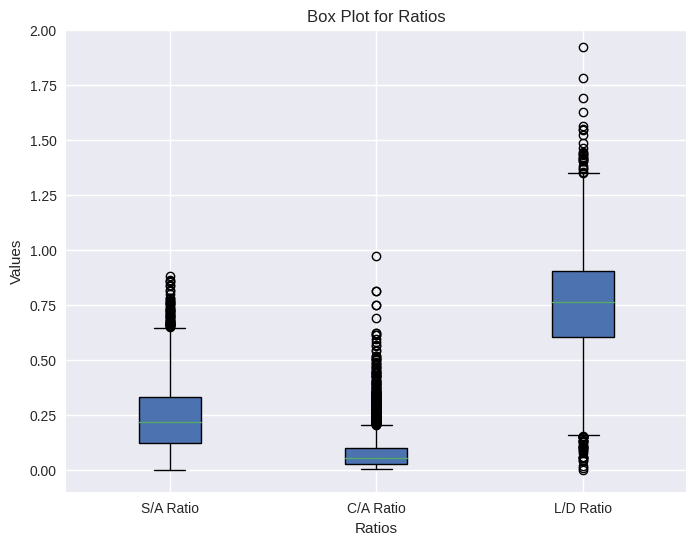

In [65]:
# Creating a list of data to plot
data_to_plot = [S_A_Ratio, C_A_Ratio, L_D_Ratio]

# Creating the box plot using Matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(data_to_plot, vert=True, patch_artist=True)
plt.xticks([1, 2, 3], ['S/A Ratio', 'C/A Ratio', 'L/D Ratio'])
plt.title('Box Plot for Ratios')
plt.ylabel('Values')
plt.xlabel('Ratios')
plt.ylim([-0.1,2])
plt.grid(True)
plt.show()

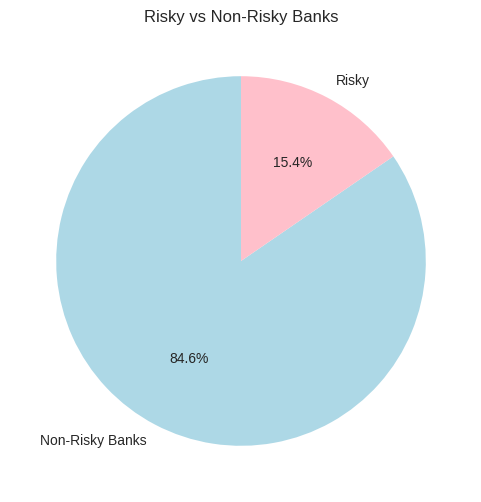

In [80]:
#Set Variables
non_risky_bank_count = 3823
risky_bank_count = 697

# Data for the two categories
categories = ['Non-Risky Banks', 'Risky']
values = [non_risky_bank_count, risky_bank_count]

# Creating the pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'pink'])
plt.title('Risky vs Non-Risky Banks')
plt.show()